In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import json
from pyhaloxml.HaloXML import HaloXML
from shapely.geometry import shape
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [8]:
adata = sc.read_h5ad("data/HT224P1.h5ad")
annotation_path = "data/C1-HT224P1-S1Fc2U1.annotations"

In [9]:
# if not already stored in X and Y 
# adata.obs["X"] = adata.obsm["X_spatial"][:,0]
# adata.obs["Y"] = adata.obsm["X_spatial"][:,1]
adata.obs["X"] = adata.obs["pxl_row_in_fullres"]
adata.obs["Y"] = adata.obs["pxl_col_in_fullres"]
adata.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,sample,X,Y
AAACAAGTATCTCCCA-1,1,50,102,14754,12376,HT224P1,14754,12376
AAACAGCTTTCAGAAG-1,1,43,9,3211,10789,HT224P1,3211,10789
AAACAGGGTCTATATT-1,1,47,13,3702,11656,HT224P1,3702,11656
AAACATTTCCCGGATT-1,1,61,97,14117,14749,HT224P1,14117,14749
AAACCCGAACGAAATC-1,1,45,115,16375,11306,HT224P1,16375,11306
...,...,...,...,...,...,...,...,...
TTGTTAGCAAATTCGA-1,1,22,42,7339,6276,HT224P1,7339,6276
TTGTTCAGTGTGCTAC-1,1,24,64,10069,6726,HT224P1,10069,6726
TTGTTGTGTGTCAAGA-1,1,31,77,11675,8249,HT224P1,11675,8249
TTGTTTCACATCCAGG-1,1,58,42,7289,14057,HT224P1,7289,14057


In [23]:
def transfer_halo_annotations_to_adata(
    annotation_path,
    adata,
    flip_x=False,
    flip_y=False,
    rotation=0, 
    x_shift=0,
    y_shift=0,
    align_to_visium=True,
    save_path=None,
    spot_diameter=55,
    plot=True,
):
    """
    Transfer HALO annotation labels to Visium spots in an AnnData object.

    Parameters
    ----------
    annotation_path : str
        Path to the .annotations file.
    adata : AnnData
        AnnData object with spatial coordinates in obsm["X_spatial"].
    flip_x : bool, default False
        Whether to flip the X coordinates.
    flip_y : bool, default False
        Whether to flip the Y coordinates.
    rotation : float, default 0
        Angle in degrees to rotate the coordinates (clockwise is positive).
        For example, rotation=90 rotates 90 degrees clockwise.
    x_shift : float, default 0
        Value to shift X coordinates.
    y_shift : float, default 0
        Value to shift Y coordinates.
    align_to_visium : bool, default True
        Whether to align annotation coordinates to Visium spots.
    save_path : str or None
        If provided, path to save the updated AnnData object.
    spot_diameter : float, default 55
        Diameter of Visium spots (in same units as coordinates).
    plot : bool, default True
        Whether to plot overlays and results.
    
    """
    # Load HALO annotations
    hx = HaloXML()
    hx.load(annotation_path)
    hx.matchnegative()

    geojson_feats = []
    labels = []

    for layer in hx.layers:
        feats = layer.as_geojson(matchnegative=True)
        for f in feats:
            geojson_feats.append(shape(f.geometry))
            labels.append(f.properties.get("classification", "Unlabeled"))

    gdf = gpd.GeoDataFrame({'label': labels, 'geometry': geojson_feats}, crs=None)
    gdf["label"] = gdf["label"].apply(lambda d: d.get("name") if isinstance(d, dict) else d)

    x = adata.obs["X"].copy()
    y = adata.obs["Y"].copy()

    # Always apply the same transformations regardless of align_to_visium
    # 1. Flip
    if flip_x:
        x = x.max() - (x - x.min())
    if flip_y:
        y = y.max() - (y - y.min())
    # 2. Shift
    x_aligned = x + x_shift
    y_aligned = y + y_shift
    # 3. Rotation
    if rotation != 0:
        theta = -np.deg2rad(rotation)
        x_mean = np.mean(x_aligned)
        y_mean = np.mean(y_aligned)
        x_shifted = x_aligned - x_mean
        y_shifted = y_aligned - y_mean
        x_rot = x_shifted * np.cos(theta) - y_shifted * np.sin(theta)
        y_rot = x_shifted * np.sin(theta) + y_shifted * np.cos(theta)
        x_aligned = x_rot + x_mean
        y_aligned = y_rot + y_mean


    # Create GeoDataFrame for Visium spots
    spots_gdf = gpd.GeoDataFrame(
        adata.obs.copy(),
        geometry=gpd.points_from_xy(
            x_aligned,
            y_aligned
        ),
        crs=None
    )

    if plot:
        fig, ax = plt.subplots(figsize=(10, 10))
        gdf.plot(
            ax=ax,
            column="label",
            categorical=True,
            legend=True,
            cmap="tab20",
            edgecolor="black",
            linewidth=0.5,
            alpha=0.4
        )
        # Plot each spot as a circle with the correct diameter
        spot_radius = spot_diameter / 2
        for x0, y0 in zip(x_aligned, y_aligned):
            circle = plt.Circle((x0, y0), spot_radius, color='black', alpha=0.5, fill=False, linewidth=1)
            ax.add_patch(circle)
        # Optionally, overlay the spot centers as points for clarity
        ax.scatter(
            x_aligned, y_aligned,
            color='black',
            s=8,
            alpha=0.8,
            label='Visium Spot Centers'
        )
        plt.title("Halo Annotations and Visium Spots (Spot Diameter Shown)")
        plt.axis("equal")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Buffer spots to create spot areas
    spot_radius = spot_diameter / 2
    buffered_spots_gdf = gpd.GeoDataFrame(
        adata.obs.copy(),
        geometry=[Point(x, y).buffer(spot_radius) for x, y in zip(x_aligned, y_aligned)],
        crs=None
    )
    # Ensure both are GeoDataFrames
    buffered_spots_gdf = gpd.GeoDataFrame(buffered_spots_gdf, geometry='geometry', crs=None)
    gdf = gpd.GeoDataFrame(gdf, geometry='geometry', crs=None)

    # Drop the 'barcode' column if it exists before resetting index
    if 'barcode' in buffered_spots_gdf.columns:
        buffered_spots_gdf = buffered_spots_gdf.drop(columns=['barcode'])

    # Spatial join: which annotation polygons overlap each spot
    joined = gpd.sjoin(buffered_spots_gdf, gdf, how="left", predicate="intersects")

    # For each spot, calculate the percentage of its area covered by each label
    # This is done by intersecting the spot buffer with each annotation polygon and summing the area
    spot_label_areas = {}
    spot_total_areas = {}
    for idx, spot in buffered_spots_gdf.iterrows():
        spot_geom = spot.geometry
        overlaps = joined.loc[joined.index == idx]
        label_area_dict = {}
        total_area = spot_geom.area
        for label in gdf["label"].unique():
            polys = gdf[gdf["label"] == label]
            area = 0.0
            for poly in polys.geometry:
                inter = spot_geom.intersection(poly)
                area += inter.area
            label_area_dict[label] = area
        spot_label_areas[idx] = label_area_dict
        spot_total_areas[idx] = total_area

    # Convert to DataFrame
    label_area_df = pd.DataFrame.from_dict(spot_label_areas, orient='index')
    total_area_series = pd.Series(spot_total_areas)
    label_frac_df = label_area_df.div(total_area_series, axis=0).fillna(0)

    # Assign to AnnData obs
    dominant_label = label_frac_df.idxmax(axis=1)
    max_fraction = label_frac_df.max(axis=1)

    adata.obs["halo_label"] = adata.obs.index.map(dominant_label)
    adata.obs["halo_label_frac"] = adata.obs.index.map(max_fraction)

    for label in label_frac_df.columns:
        adata.obs[f"halo_frac_{label}"] = adata.obs.index.map(label_frac_df[label])

    if save_path is not None:
        print(f"Saving updated AnnData to {save_path} ...")
        adata.write_h5ad(save_path)

    if plot:
        print("Plotting halo-labeled scatter plot...")
        fig, ax = plt.subplots(figsize=(8, 8))
        scatter = ax.scatter(
            x_aligned, y_aligned,
            c=adata.obs["halo_label"].astype("category").cat.codes,
            cmap="tab20", s=10, alpha=0.8
        )
        ax.set_title("Scatter by Halo Label")
        ax.set_xlabel("X (transformed)")
        ax.set_ylabel("Y (transformed)")
        plt.axis("equal")
        plt.show()

    return adata

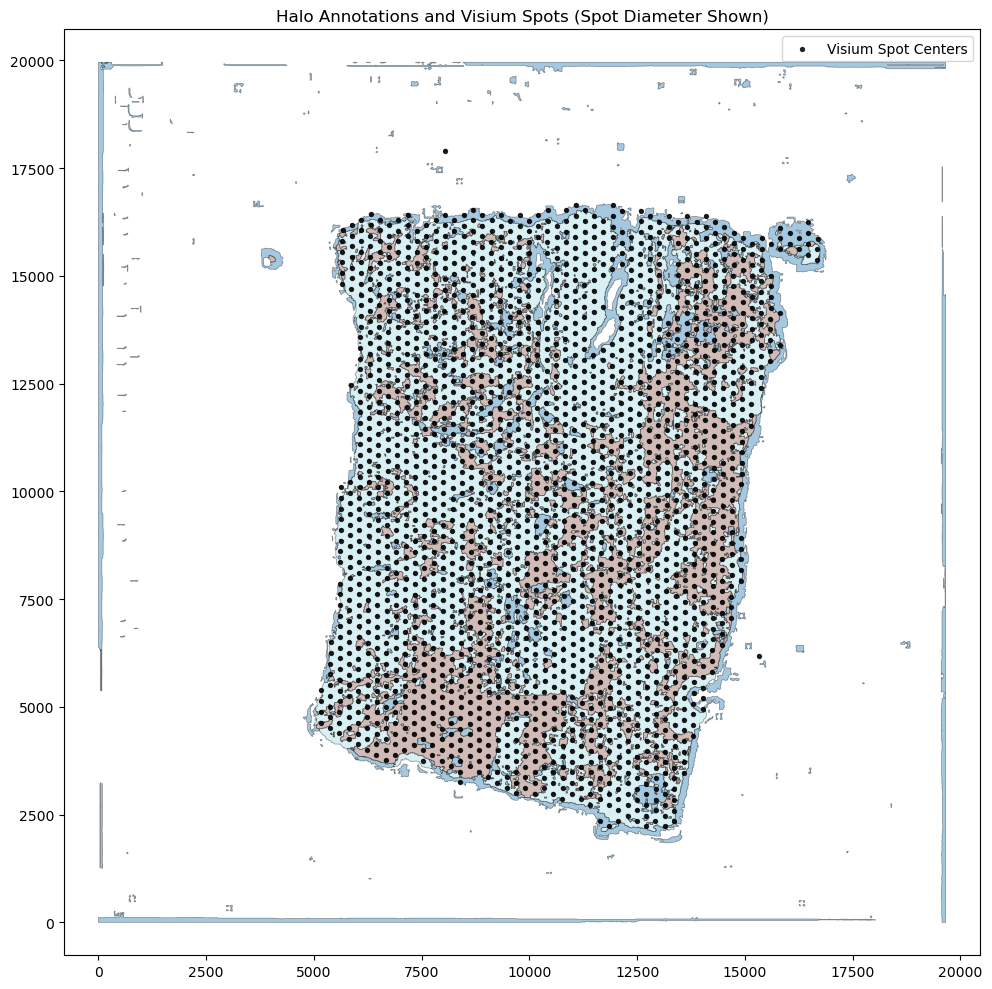

Plotting halo-labeled scatter plot...


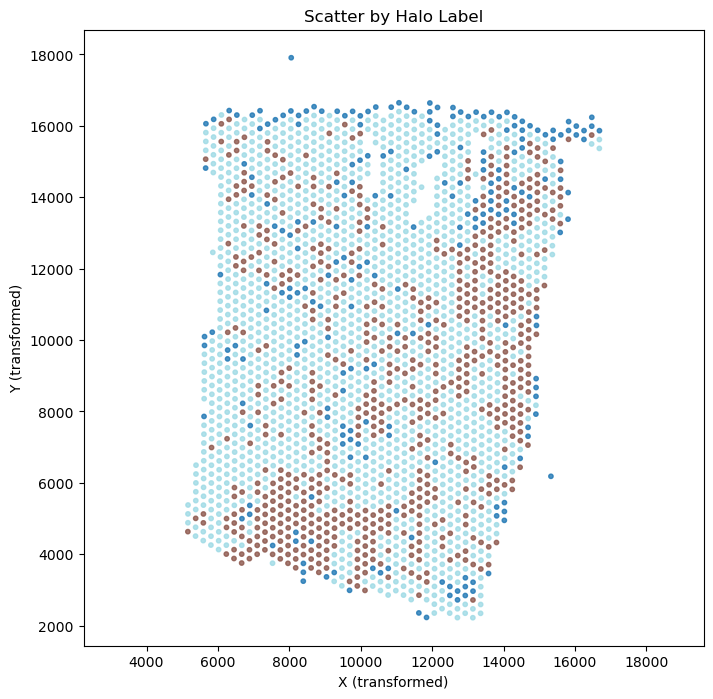

In [20]:
updated_adata = transfer_halo_annotations_to_adata(
    annotation_path=annotation_path,
    adata=adata,
    flip_x=True,
    flip_y=False,
    rotation = 90,
    x_shift= 300,
    y_shift=-500,
    align_to_visium=True, # Set to false if just testing alignment 
    save_path=None, # can save off 
    spot_diameter=55,
    plot=True
)

In [22]:
adata.obs

,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres,sample,X,Y,halo_label,halo_label_frac,halo_frac_Adipose,halo_frac_Stromal,halo_frac_Tumor
AAACAAGTATCTCCCA-1,1,50,102,14754,12376,HT224P1,14754,12376,Tumor,1.000000,0.000000,0.000000,1.000000
AAACAGCTTTCAGAAG-1,1,43,9,3211,10789,HT224P1,3211,10789,Stromal,0.979811,0.000000,0.979811,0.020189
AAACAGGGTCTATATT-1,1,47,13,3702,11656,HT224P1,3702,11656,Stromal,0.975601,0.000000,0.975601,0.024399
AAACATTTCCCGGATT-1,1,61,97,14117,14749,HT224P1,14117,14749,Stromal,1.000000,0.000000,1.000000,0.000000
AAACCCGAACGAAATC-1,1,45,115,16375,11306,HT224P1,16375,11306,Adipose,0.919546,0.919546,0.000000,0.080454
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTAGCAAATTCGA-1,1,22,42,7339,6276,HT224P1,7339,6276,Tumor,1.000000,0.000000,0.000000,1.000000
TTGTTCAGTGTGCTAC-1,1,24,64,10069,6726,HT224P1,10069,6726,Stromal,1.000000,0.000000,1.000000,0.000000
TTGTTGTGTGTCAAGA-1,1,31,77,11675,8249,HT224P1,11675,8249,Stromal,0.699289,0.000000,0.699289,0.300711
TTGTTTCACATCCAGG-1,1,58,42,7289,14057,HT224P1,7289,14057,Tumor,1.000000,0.000000,0.000000,1.000000
